## Clustering No Jerárquico (II): DBSCAN

### Configuración

Para comenzar ejecuta la siguiente celda que está únicamente dedicada a hacer los imports y configuraciones necesarias para poder funcionar correctamente con este notebook de apoyo.

In [1]:
# Common imports
import numpy as np
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='b'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=15, linewidths=20,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo de clustering que se basa en la densidad de los datos para formar clusters. A diferencia de métodos como k-means, DBSCAN no requiere que se especifique el número de clusters de antemano. En su lugar, identifica las áreas de alta densidad que están separadas entre sí por áreas de baja densidad.

La principal ventaja de DBSCAN es su capacidad para encontrar clusters de cualquier forma y tamaño, y su habilidad para identificar y separar outliers o ruido de los datos. Es especialmente útil cuando no se tiene una idea clara del número de clusters o cuando los clusters pueden tener formas irregulares.

### Funcionamiento de DBSCAN

Este algoritmo define los grupos como regiones continuas de alta densidad. Así es como funciona:

+ Para cada instancia, el algoritmo cuenta cuántas instancias se encuentran dentro de una pequeña distancia `eps` (epsilon) de ella. Esta región se llama $vecindario-\epsilon$ (en inglés $\epsilon-neighborhood$). `eps` es un hiperparámetro del modelo, es decir nosotros tenemos que elegir el valor adecuado en cada caso.

+ Si una instancia tiene al menos `min_samples` en su vecindario (incluyéndose a sí misma), entonces se considera una instancia central, o "core instance". En otras palabras, las instancias cores son aquellas que se encuentran en regiones densas (con "muchos puntos" -> "min_samples"). Si `min_samples` es otro hiperparámetro del modelo y lo tenemos que escoger nosotros, de nuevo dependiendo del contexto en el que estemos trabajando.

+ El algoritmo considera que todas las instancias en la vecindad de una instancia central pertenecen al mismo clúster. Ten en cuenta que que este vecindario puede incluir otros casos centrales (o core instances) y por tanto va "fusionando" los vecindarios de esas otras instancias cores en un único cluster. Si el vecindario de la instancia 4 (core) incluye la 23, la 101 y la 1000 y, por ejemplo, la 23 es core también con instancias 12,106 y 45 entonces todas forman un único cluster (4,23,101,1000,12,106,45) y así sucesivamente.

+ Cualquier instancia que no sea una instancia central y no tenga una en su vecindario se considera una "anomalía" (y,si repasas los pasos anteriores, no se le puede asignar ningún clúster y se la etiquetará como -1, como veremos)



In [3]:
from sklearn.datasets import make_moons

In [4]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

O sea que partimos del siguiente dataset:

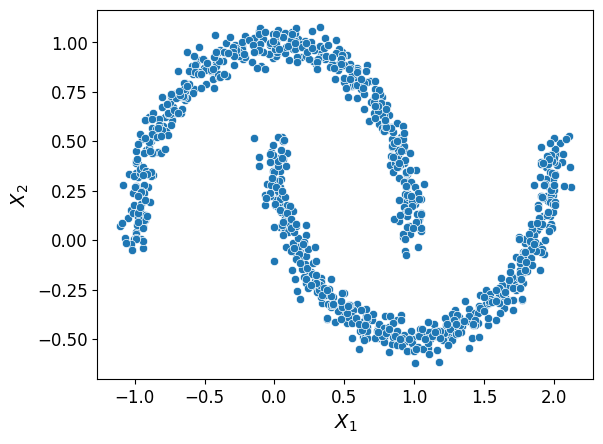

In [6]:
sns.scatterplot(x = X[:,0], y = X[:,1])
plt.xlabel("$X_1$")
plt.ylabel("$X_2$");

En el que podríamos decir que hay dos clusters o agrupaciones (el "churro" superior y el "churro" inferior), veamos cómo se las gasta DBSCAN para identificarlas.

In [7]:
from sklearn.cluster import DBSCAN # Siempre, por ahora, tirando de sklearn

In [8]:
'''
Empieza con un punto aleatorio y segun va montando un cluster, busca en los puntos vecinos
eps: (epsilon) distancia sobre la que busca vecinos
min_samples: minimo numero de vecinos para considerarse cluster
'''
dbscan = DBSCAN(eps=0.05,
                min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [9]:
# El algoritmo
print(dbscan)

# Todos los datos etiquetados
print(len(dbscan.labels_))

# Los 10 primeros labels
print(dbscan.labels_[:10])

# Cuantos clusters ha montado
print(np.unique(dbscan.labels_))

DBSCAN(eps=0.05)
1000
[ 0  2 -1 -1  1  0  0  0  2  5]
[-1  0  1  2  3  4  5  6]


Como ya adelantábamos existe una clase -1 que significa que las instancias etiquetadas con dicho valor se consideran anomalías.



Los índices las instancias core se almacenan en el atributo `core_sample_indices_`, y los valores de las features de dichas instancias cores están disponibles en el atributo `components_`:


In [10]:
# Cuantos core_sample_indices_
print(len(dbscan.core_sample_indices_))

# Los indices de los 10 primeros core_sample
print(dbscan.core_sample_indices_[:10])

# La posicion (coordenadas) de los 5 primeros core_sample
print(dbscan.components_[:5])

808
[ 0  4  5  6  7  8 10 11 12 13]
[[-0.02137124  0.40618608]
 [-0.84192557  0.53058695]
 [ 0.58930337 -0.32137599]
 [ 0.29248724 -0.20696309]
 [-0.02637836  0.44766267]]


In [11]:
# Aumentemos epsilon para que tenga mayor rango y se formen menos clusters
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

Pero como todo esto queda muy etéreo, vamos a representarlo gráficamente que siempre ayuda a aterrizarlo:

In [12]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

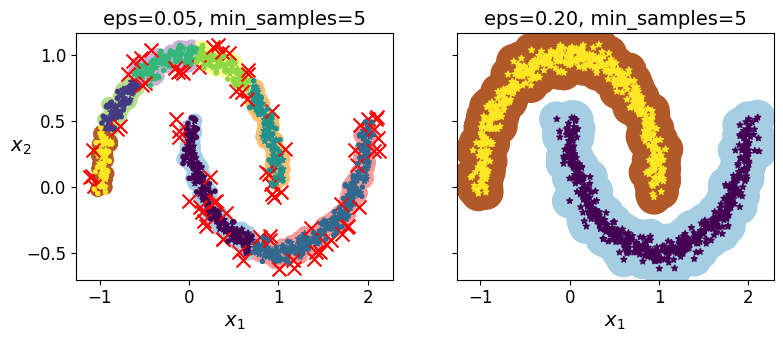

In [13]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)


plt.show()


Nuestro dbscan, el de epsilon pequeño, marcó instancias como anomalías, además de siete grupos diferentes, queríamos grupos muy densos (instnacias concentradas en "espacio"). En cambio, en cuanto permitimos un eps mayor es decir si ampliamos el vecindario de cada instancia, tenemos la agrupación a la derecha, que hace una detección perfecta. 

#### "Predicciones" con  DBSCAN

Sorprendentemente, la clase DBSCAN no tiene un método predict(), aunque tiene un método fit_predict(). En otras palabras, no puede asignar clúster a una nueva instancia (datos que no estuvieran en el train con el que se haya construido el DBSCAN). 


La idea es que partimos de un dataset ya "etiquetado", al usar el DBSCAN, y lo que hay que hacer ahora es usarlo como dataset de train de cualquier clasificador supervisado ya conocido.

Por ejemplo, podemos entrenar un KNN para clasificación. 


In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
'''
No tiene .predict. Ya están los datos etiquetados y se le deja al usuario predecir con
el algoritmo de clasificacion que prefiera. Por ejemplo, KNN.
'''
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_]) # Fijate que se entrena con las instancias core, no con todas las instancias (aunque podríamos hacerlo con todas)

KNeighborsClassifier(n_neighbors=50)

Ten en cuenta que solo entrenamos al clasificador en las instancias core, pero también podríamos haber elegido entrenarlo en todas las instancias, o en todas menos en las anomalías: esta elección depende de la tarea final. 

Y ahora podemos`hacer predicciones/etiquetar nuevas instancias no icluidas en el dataset inicial:

In [16]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [17]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Vamos a ver donde estarían esos nuevos puntos, las regiones de decisión de KNN que explicarán porque los ha categorizado como tal y si nos interesa cambiar la clasficiación:

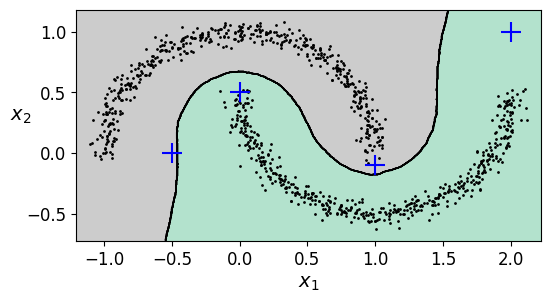

In [18]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

Viendo esta situación podríamos querer establecer algún tipo de criterio para que los puntos como [-0.5, 0] o [2,1] sean considerados anomalías. Quizás que la distancia a los vecinos sea menor que un valor concreto y para distancias superiores lo consideramos una anomalía: 

In [19]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1) # método que 
                                                        #devuelve la distancia y el índice de los vecinos 
                                                        #indicados por n_neighbors (devuelve los vecinos ordenados 
                                                        #por distancia), es decir con n_neighbors = 1 recupero 
                                                        # el vecino más cercano
y_pred = dbscan2.labels_[dbscan2.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1 # Básicamente lo que dice es que si la distancia al vecino más cercano es 0.2 (el epsilon del modelo DBSCAN), en 
                        # este caso, quiere decir que es una anomalía
                        # Si, no se queda con la clase de ese vecino
print(y_pred)   
y_pred.ravel()


[[-1]
 [ 0]
 [ 1]
 [-1]]


array([-1,  0,  1, -1], dtype=int64)

En resumen, DBSCAN es un algoritmo muy simple pero potente capaz de identificar cualquier número de grupos de cualquier forma. Es resistente a los valores atípicos, y solo tiene dos hiperparámetros (eps y min_samples). 

Sin embargo, si la densidad varía significativamente entre los grupos, puede ser imposible capturar todos los grupos correctamente. Y además tiene otros "inconvenientes" en tiempo de computación que creecen no linealmente con el número de instancias. 
